In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import spearmanr


In [2]:
# Load the dataset
file_path = "../data/merged_dataset_v0.csv"
data = pd.read_csv(file_path)


In [3]:
# Ensure conferences have data for correct years
valid_years = {
    "cvpr": [2019, 2020, 2021, 2022, 2023, 2024],
    "iccv": [2019, 2021, 2023],
    "wacv": [2020, 2021, 2022, 2023, 2024]
}

# Filter the data to keep only valid years for each conference
data_filtered = data[data.apply(lambda x: x["Conference"].lower() in valid_years and x["Year"] in valid_years[x["Conference"].lower()], axis=1)]


In [4]:
# Group by Year, Conference, and PaperType to count the number of papers
grouped_counts = data_filtered.groupby(["Year", "Conference", "PaperType"]).size().reset_index(name="Count")

# Pivot the data to get counts for 'Company' and 'Academia' side-by-side
pivot_table = grouped_counts.pivot(index=["Year", "Conference"], columns="PaperType", values="Count").fillna(0)

# Calculate the company/academia ratio
pivot_table["Company_Academia_Ratio"] = pivot_table["Company"] / (pivot_table["Academia"] + pivot_table["Company"])

# Reset the index for plotting
pivot_table = pivot_table.reset_index()

# Convert conference names to uppercase for plotting
pivot_table["Conference"] = pivot_table["Conference"].str.upper()


In [5]:
# Initialize an empty dictionary to store results
spearman_results = {}

# Compute yearly aggregated data for all conferences
yearly_aggregated = pivot_table.groupby("Year").agg({
    'Company': 'sum',
    'Academia': 'sum'
}).reset_index()

# Calculate the total company/academia ratio across all conferences
yearly_aggregated["Company_Academia_Ratio"] = yearly_aggregated["Company"] / (yearly_aggregated["Academia"] + yearly_aggregated["Company"])

# Add the aggregated data to the pivot table for plotting
pivot_table = pd.concat([pivot_table, yearly_aggregated.assign(Conference='Total')])

# Calculate Spearman's Rank Correlation for each conference
for conference in pivot_table["Conference"].unique():
    conf_data = pivot_table[pivot_table["Conference"] == conference]
    spearman_corr, p_value = spearmanr(conf_data['Year'], conf_data['Company_Academia_Ratio'])
    spearman_results[conference] = {
        'Spearman Rank Correlation': spearman_corr,
        'P-value': p_value
    }


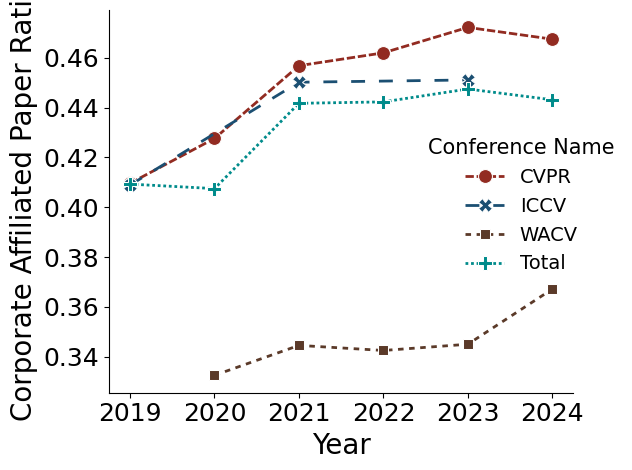

In [8]:
# Custom palette
custom_palette = {
    'CVPR': '#922B21',
    'ICCV': '#1B4F72',
    'WACV': '#5B3A29',
    'Total': '#008B8B'
}

# Plot the data
sns.lineplot(
    data=pivot_table,
    x="Year",
    y="Company_Academia_Ratio",
    hue="Conference",
    style="Conference",
    markers=True,
    dashes={"WACV": (2,2), "ICCV": (5,5), "CVPR": (3,1), "Total": (1,1)},
    palette=custom_palette,
    markersize=10,
    linewidth=2
)

# Customize plot
plt.ylabel("Corporate Affiliated Paper Ratio", fontsize=20, fontweight='medium')
plt.xlabel("Year", fontsize=20, fontweight='medium')
plt.legend(title="Conference Name",title_fontsize='15',loc="upper left", bbox_to_anchor=(0.65, 0.71), fontsize=14, frameon=False) 
plt.tight_layout(pad=2)

plt.xticks(fontsize=18)  # Resize x-axis labels
plt.yticks(fontsize=18)  # Resize y-axis labels
sns.despine() 
plt.tight_layout()

# Save the plot
plt.show()


The plot shows an increasing trend (from 2019 to 2024) in corporate contributions, with CVPR and ICCV maintaining higher ratios compared to WACV and reaching record levels in corporate affiliation. 

In [9]:
# Print the Spearman results
for conference, results in spearman_results.items():
    print(f"Spearman Results for {conference}:")
    print(f"  Spearman Rank Correlation: {results['Spearman Rank Correlation']:.4f}")
    print(f"  P-value: {results['P-value']:.4f}")
    if results['P-value'] < 0.05:
        print(f"  There is a significant monotonic relationship between year and corporate paper ratio for {conference}.")
    else:
        print(f"  There is no significant monotonic relationship between year and corporate paper ratio for {conference}.")
    print()

Spearman Results for CVPR:
  Spearman Rank Correlation: 0.9429
  P-value: 0.0048
  There is a significant monotonic relationship between year and corporate paper ratio for CVPR.

Spearman Results for ICCV:
  Spearman Rank Correlation: 1.0000
  P-value: 0.0000
  There is a significant monotonic relationship between year and corporate paper ratio for ICCV.

Spearman Results for WACV:
  Spearman Rank Correlation: 0.9000
  P-value: 0.0374
  There is a significant monotonic relationship between year and corporate paper ratio for WACV.

Spearman Results for Total:
  Spearman Rank Correlation: 0.8857
  P-value: 0.0188
  There is a significant monotonic relationship between year and corporate paper ratio for Total.



Spearman’s rank correlation coefficients all of which indicate strong positive correlations (coefficients exceeding 0.88) with statistically significant values (p < 0.05).